# Ted Talks

Two datasets:
- `ted_main.csv`
- `transcript.csv`


These notebook is divided in 4 parts:
<ol>
    <li> <b>Part A</b>: Data loading and preprocessing </li>
    <li> <b>Part B</b>: Saving the processed dataframes </li>
    <li> <b>Part C</b>: Exploritory data analysis </li>
    <li> <b>Part D</b>: Experimental stuff </li>
</ol>

In [1]:
# TODO(all): clean up and order the imports at the end
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews, twitter_samples

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import twitter_samples, stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk import FreqDist, classify, NaiveBayesClassifier

import re, string, random

from ast import literal_eval

# Uncomment this if you want to see all rows and columns when displaying a pandas object
# pd.set_option("display.max_rows", None, "display.max_columns", None)

## Part A. Data loading and preprocessing

In [2]:
df = pd.read_csv('data/ted_main.csv')
df2 = pd.read_csv('data/transcripts.csv')
df2.info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2467 entries, 0 to 2466
Data columns (total 2 columns):
transcript    2467 non-null object
url           2467 non-null object
dtypes: object(2)
memory usage: 38.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 17 columns):
comments              2550 non-null int64
description           2550 non-null object
duration              2550 non-null int64
event                 2550 non-null object
film_date             2550 non-null int64
languages             2550 non-null int64
main_speaker          2550 non-null object
name                  2550 non-null object
num_speaker           2550 non-null int64
published_date        2550 non-null int64
ratings               2550 non-null object
related_talks         2550 non-null object
speaker_occupation    2544 non-null object
tags                  2550 non-null object
title                 2550 non-null object
url                   2550 non-null o

The talks dataset contains 17 columns. According to the Kaggle website these are:
<ol>
    <li> <b>name</b>: The official name of the TED Talk. Includes the title and the speaker. *Use this as the unique id in our dataframe </li>
    <li> <b>title</b>: The title of the talk </li>
    <li> <b>main_speaker</b>: The first named speaker of the talk </li>    
    <li> <b>speaker_occupation</b>: The occupation of the main speaker </li>
    <li> <b>num_speaker</b>: The number of speakers in the talk </li>
    <li> <b>description</b>: A blurb of what the talk is about </li>
    <li> <b>duration</b>: The duration of the talk in seconds </li>
    <li> <b>event</b>: The TED/TEDx event where the talk took place </li>
    <li> <b>languages</b>: The number of languages in which the talk is available </li>
    <li> <b>film_date</b>: The Unix timestamp of the filming </li>
    <li> <b>published_date</b>: The Unix timestamp for the publication of the talk on TED.com </li>
    <li> <b>tags</b>: The themes associated with the talk </li>
    <li> <b>views</b>: The number of views on the talk </li>
    <li> <b>url</b>: The URL of the talk </li>
    <li> <b>ratings</b>: A stringified dictionary of the various ratings given to the talk (inspiring, fascinating, jaw dropping, etc.) </li>
    <li> <b>comments</b> The number of first level comments made on the talk </li>
    <li> <b>related_talks</b> A list of dictionaries of recommended talks to watch next </li>
</ol>

The transcripts dataset contains only 2 columns.
<ol>
    <li> <b>transcript</b>: The transcript of the talk. Contains audience reactions. </li>
    <li> <b>url</b>: The url of the talk. Will use this to join the 2 datasets. </li>
</ol>

In [3]:
display(df.head(5))

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869


In [4]:
# Check if all rows are unique
df['name'].value_counts().sort_values(ascending=False)

Carl Honoré: In praise of slowness                                           1
Eric Dishman: Take health care off the mainframe                             1
Patsy Rodenburg: Why I do theater                                            1
Larry Page: Where’s Google going next?                                       1
Richard Weller: Could the sun be good for your heart?                        1
                                                                            ..
Neha Narula: The future of money                                             1
Philippa Neave: The unexpected challenges of a country's first election      1
Stefan Sagmeister: 7 rules for making more happiness                         1
Drew Dudley: Everyday leadership                                             1
Anote Tong: My country will be underwater soon -- unless we work together    1
Name: name, Length: 2550, dtype: int64

In [5]:
# Check if all rows are unique
df2_value_counts = df2['url'].value_counts().sort_values(ascending=False)
duplicate_rows = df2_value_counts[df2_value_counts > 1]
print(duplicate_rows)

https://www.ted.com/talks/rob_reid_the_8_billion_ipod\n                                 2
https://www.ted.com/talks/jonathan_haidt_humanity_s_stairway_to_self_transcendence\n    2
https://www.ted.com/talks/brene_brown_listening_to_shame\n                              2
Name: url, dtype: int64


In [6]:
df2[df2['url'].isin(duplicate_rows.index)]['transcript'].value_counts().values

array([2, 2, 2])

Some rows in the transcript dataset are not unique. <br />
Looking at the transcripts for these 3 talks, seems like these are just duplicates. <br />
We delete these 3 rows. <br />

In [7]:
# We could have just called this method and then compare the shape of the
# dataframe before and after.
df2 = df2.drop_duplicates()
df = df.drop_duplicates()

In [8]:
# Add the transcript to the main data frame
df = pd.merge(df, df2, on='url', how='left')
print('We have ' + str(df.shape[0]) + ' data points')

We have 2550 data points


### Missing data?

In [9]:
df.isnull().sum()

comments               0
description            0
duration               0
event                  0
film_date              0
languages              0
main_speaker           0
name                   0
num_speaker            0
published_date         0
ratings                0
related_talks          0
speaker_occupation     6
tags                   0
title                  0
url                    0
views                  0
transcript            86
dtype: int64

Quite many are missing transcription for some reason. Fill this missing data with an empty string. We could manually search each one on Wikipedia and manually fill in this information.

In [10]:
df.transcript.fillna('', inplace=True)

Only some speakers do not have their occupations in the dataset. We could manually search each one on Wikipedia and manually fill in this information.
Replaced them with "Unknown" for now.

In [11]:
display(df[df.isnull().any(axis=1)])
df.speaker_occupation.fillna('Unknown', inplace = True)

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,transcript
1113,145,"After a crisis, how can we tell if water is sa...",217,TEDGlobal 2011,1310601600,38,Sonaar Luthra,Sonaar Luthra: Meet the Water Canary,1,1326731605,"[{'id': 10, 'name': 'Inspiring', 'count': 73},...","[{'id': 523, 'hero': 'https://pe.tedcdn.com/im...",NaN,"['TED Fellows', 'design', 'global development'...",Meet the Water Canary,https://www.ted.com/talks/sonaar_luthra_meet_t...,353749,Cholera was reported in Haiti for the first ti...
1192,122,"The Pirate Party fights for transparency, anon...",1097,TEDxObserver,1331424000,10,Rick Falkvinge,Rick Falkvinge: I am a pirate,1,1333289675,"[{'id': 8, 'name': 'Informative', 'count': 156...","[{'id': 1329, 'hero': 'https://pe.tedcdn.com/i...",NaN,"['Internet', 'TEDx', 'global issues', 'politic...",I am a pirate,https://www.ted.com/talks/rick_falkvinge_i_am_...,181010,Thank y'all!This is going to be a motivational...
1220,257,"As you surf the Web, information is being coll...",399,TED2012,1330473600,32,Gary Kovacs,Gary Kovacs: Tracking our online trackers,1,1336057219,"[{'id': 23, 'name': 'Jaw-dropping', 'count': 9...","[{'id': 1370, 'hero': 'https://pe.tedcdn.com/i...",NaN,"['Internet', 'advertising', 'business', 'priva...",Tracking our online trackers,https://www.ted.com/talks/gary_kovacs_tracking...,2098639,"I don't know why, but I'm continually amazed t..."
1656,140,"In this lovely talk, TED Fellow Ryan Holladay ...",389,TED@BCG San Francisco,1383091200,33,Ryan Holladay,Ryan Holladay: To hear this music you have to ...,1,1389369735,"[{'id': 1, 'name': 'Beautiful', 'count': 211},...","[{'id': 1152, 'hero': 'https://pe.tedcdn.com/i...",NaN,"['TED Fellows', 'entertainment', 'music', 'tec...",To hear this music you have to be there. Liter...,https://www.ted.com/talks/ryan_holladay_to_hea...,1284510,(Music) For any of you who have visited or liv...
1911,48,What do you do with an outdated encyclopedia i...,366,TEDYouth 2014,1415059200,34,Brian Dettmer,Brian Dettmer: Old books reborn as art,1,1423238442,"[{'id': 1, 'name': 'Beautiful', 'count': 361},...","[{'id': 610, 'hero': 'https://pe.tedcdn.com/im...",NaN,"['TEDYouth', 'art', 'books', 'creativity']",Old books reborn as art,https://www.ted.com/talks/brian_dettmer_old_bo...,1159937,I'm an artist and I cut books. This is one of ...
1949,70,Photographer Boniface Mwangi wanted to protest...,440,TEDGlobal 2014,1413763200,33,Boniface Mwangi,Boniface Mwangi: The day I stood up alone,1,1427989423,"[{'id': 3, 'name': 'Courageous', 'count': 614}...","[{'id': 1757, 'hero': 'https://pe.tedcdn.com/i...",NaN,"['TED Fellows', 'activism', 'art', 'corruption...",The day I stood up alone,https://www.ted.com/talks/boniface_mwangi_boni...,1342431,"People back home call me a heckler, a troublem..."


## Preprocessing
<ol>
    <li>give ids to talks</li>
    <li>transform the <b>film_date</b> and <b>publish_date</b> into datetime objects</li>
    <li>transform the <b>tags</b>, <b>ratings</b> and <b>related_talks</b> stringified dictionary into dictionary objects</li>
    <li>expand the <b>ratings</b> column in different columns </li>
    <li>fill in missing values for speaker_occupation column</li>
    <li>constuct related talks graph</li>
    <li>compute speed of talk as number of words divided by duration of the talk in minutes</li>
    <li>add a new column called <b>event_type</b> to easily group differet ted talks types
    <li>reorder columns in a more intuitive order</li>
</ol>

In [12]:
# 1
# Give ids to talks
df['talk_id'] = df.index

In [13]:
# 2
# Transform the film_date and publish_date to datetime objects
# Keep only the day month and year
df['film_date'] = pd.to_datetime(df['film_date'], unit='s').dt.strftime('%d/%m/%Y')
df['published_date'] = pd.to_datetime(df['published_date'], unit='s').dt.strftime('%d/%m/%Y')
df['film_date'] = pd.to_datetime(df['film_date'])
df['published_date'] = pd.to_datetime(df['published_date'])

In [14]:
# 3
# Tranfrom stringified dictionary to actual dictionary and stringified list to actual list
df['tags'] = df['tags'].apply(lambda x: literal_eval(x))
df['ratings'] = df['ratings'].apply(lambda x: literal_eval(x))
df['related_talks'] = df['related_talks'].apply(lambda x: literal_eval(x))

In [15]:
# 4
# Expand the ratings column in different columns
def extract_ratings_name(x):
    rating_names = []
    for rating in x:
        rating_names.append(str(rating['name']).lower())
    rating_names.sort()
    return rating_names

ratings_name = extract_ratings_name(df.iloc[0][['ratings']][0])
print('For each rating we have ' + str(len(ratings_name)) + ' categories: ' + str(ratings_name))
print('One rating has the following attributes: ' + str(df.iloc[0][['ratings']][0][0]))
 
for index, row in df.iterrows():
    for item in row['ratings']:
        df.loc[index, item['name'].lower()] = int(item['count'])
display(df[['name'] + ratings_name])        

For each rating we have 14 categories: ['beautiful', 'confusing', 'courageous', 'fascinating', 'funny', 'informative', 'ingenious', 'inspiring', 'jaw-dropping', 'longwinded', 'obnoxious', 'ok', 'persuasive', 'unconvincing']
One rating has the following attributes: {'id': 7, 'name': 'Funny', 'count': 19645}


,name,beautiful,confusing,courageous,fascinating,funny,informative,ingenious,inspiring,jaw-dropping,longwinded,obnoxious,ok,persuasive,unconvincing
0,Ken Robinson: Do schools kill creativity?,4573.0,242.0,3253.0,10581.0,19645.0,7346.0,6073.0,24924.0,4439.0,387.0,209.0,1174.0,10704.0,300.0
1,Al Gore: Averting the climate crisis,58.0,62.0,139.0,132.0,544.0,443.0,56.0,413.0,116.0,113.0,131.0,203.0,268.0,258.0
2,David Pogue: Simplicity sells,60.0,27.0,45.0,166.0,964.0,395.0,183.0,230.0,54.0,78.0,142.0,146.0,230.0,104.0
3,Majora Carter: Greening the ghetto,291.0,32.0,760.0,132.0,59.0,380.0,105.0,1070.0,230.0,53.0,35.0,85.0,460.0,36.0
4,Hans Rosling: The best stats you've ever seen,942.0,72.0,318.0,4606.0,1390.0,5433.0,3202.0,2893.0,3736.0,110.0,61.0,248.0,2542.0,67.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2545,Duarte Geraldino: What we're missing in the de...,21.0,2.0,24.0,8.0,1.0,33.0,22.0,27.0,14.0,3.0,1.0,0.0,24.0,12.0
2546,Armando Azua-Bustos: The most Martian place on...,4.0,0.0,2.0,32.0,20.0,38.0,6.0,20.0,8.0,0.0,0.0,13.0,7.0,1.0
2547,Radhika Nagpal: What intelligent machines can ...,14.0,5.0,2.0,24.0,1.0,32.0,19.0,30.0,1.0,0.0,0.0,4.0,3.0,1.0
2548,Theo E.J. Wilson: A black man goes undercover ...,21.0,1.0,107.0,39.0,63.0,75.0,37.0,147.0,7.0,3.0,7.0,5.0,65.0,6.0


In [16]:
# 5
# Fill in missing values for speaker_occupation column
print('We have ' + str(df['speaker_occupation'].nunique()) + ' different occupations')
display(df['speaker_occupation'].value_counts())
# Fill in missing data
df['speaker_ocupation'] = df['speaker_occupation'].str.lower()
# Taken from TED website
df.loc[df['main_speaker'] == 'Sonar Luthra', 'speaker_occupation'] = 'water data wrangler'
df.loc[df['main_speaker'] == 'Ryan Holladay', 'speaker_occupation'] = 'musician'
# Taken from Wikipedia
df.loc[df['main_speaker'] == 'Rick Falkvinge', 'speaker_occupation'] = 'it entrepreneur, politician'
df.loc[df['main_speaker'] == 'Gary Kovacs', 'speaker_occupation'] = 'ceo'
df.loc[df['main_speaker'] == 'Brian Dettmer', 'speaker_occupation'] = 'artist'
df.loc[df['main_speaker'] == 'Boniface Mwangi', 'speaker_occupation'] = 'photojournalist'

We have 1459 different occupations


Writer                             45
Artist                             34
Designer                           34
Journalist                         33
Entrepreneur                       31
                                   ..
Twitter co-founder                  1
Digital librarian                   1
Environmental policy influencer     1
Founder of Wikipedia                1
Bioethicist                         1
Name: speaker_occupation, Length: 1459, dtype: int64

In [17]:
# 6
# Construct related talks graph
unstack_edges = df.apply(lambda x: pd.Series(x['related_talks']), axis=1).stack().reset_index(level=1, drop=True)
unstack_edges.name = 'related_talk'

edges = df.drop('related_talks', axis=1).join(unstack_edges)[['title', 'related_talk']]
edges['related_talk'] = edges['related_talk'].apply(lambda x: x['title'])
edges.rename(columns = {'title': 'source', 'related_talk': 'target'}, inplace=True)
talksG = nx.from_pandas_edgelist(edges, 'source', 'target', edge_attr=None, create_using=nx.Graph())
plt.figure(figsize=(20, 20))
nx.draw(talksG, with_labels=False)
plt.savefig('figures/graph_related_talks.pdf')
plt.close()

In [18]:
print('Number of edges: {0}'.format(talksG.number_of_edges()))
print('Number of nodes: {0}'.format(talksG.number_of_nodes()))
print('Number of connected components: {0}'.format(nx.number_connected_components(talksG)))

Number of edges: 12479
Number of nodes: 2550
Number of connected components: 1


In [19]:
edges = edges.merge(df, left_on='source', right_on='title')[['source', 'target', 'talk_id']]
edges = edges.merge(df, left_on='target', right_on='title')[['source', 'target', 'talk_id_x', 'talk_id_y']]
edges.rename(columns={'id_x': 'source_id', 'id_y': 'target_id'}, inplace=True)
edges.head(5)

,source,target,talk_id_x,talk_id_y
0,Do schools kill creativity?,Bring on the learning revolution!,0,692
1,Do the green thing,Bring on the learning revolution!,344,692
2,Education innovation in the slums,Bring on the learning revolution!,715,692
3,The child-driven education,Bring on the learning revolution!,760,692
4,How web video powers global innovation,Bring on the learning revolution!,766,692


In [20]:
# 7
# Compute speed of talk as number of words divided by duration of the talk in minutes
df['number_of_words'] = df['transcript'].apply(lambda x: len(x.split()))
df['duration'] = df['duration'] / 60

df['speed_of_speech'] = df['number_of_words'] / df['duration']

In [21]:
# 8
# Add new column event_type to easily group different ted talks types
df['event_type'] = 'external'

# should still start with TED
maskSatellite =  [bool(re.search("^TED", event)) for event in df['event']] 
df.loc[maskSatellite, 'event_type'] = 'satellite'

# should still start with TED
maskTedx =  [bool(re.search("^TEDx", event)) for event in df['event']]
df.loc[maskTedx, 'event_type'] = 'tedx'

mask =  [bool(re.search("^TEDGlobal", event)) for event in df['event']]
df.loc[mask, 'event_type'] = 'global'

mask =  [bool(re.search("^TEDMED", event)) for event in df['event']]
df.loc[mask, 'event_type'] = 'med'

mask =  [bool(re.search("^TEDSalon", event)) for event in df['event']]
df.loc[mask, 'event_type'] = 'salon'

mask =  [bool(re.search("^TEDWomen", event)) for event in df['event']]
df.loc[mask, 'event_type'] = 'women'

mask =  [bool(re.search("^TEDYouth", event)) for event in df['event']]
df.loc[mask, 'event_type'] = 'youth'

mask =  [bool(re.search("^TED\d\d\d\d$", event)) for event in df['event']]
df.loc[mask, 'event_type'] = 'main'

In [22]:
# 9
# Reorder columns
df = df[['talk_id', 'name', 'title', 'description','url', 'duration', 'film_date', 'published_date',  'number_of_words', \
         'languages', 'comments', 'views', \
         'main_speaker', 'speaker_occupation', 'num_speaker', 'speed_of_speech', \
         'event', 'event_type',  \
         'related_talks', 'tags', \
         'ratings', 'beautiful', 'confusing', 'courageous', \
         'fascinating', 'funny', 'informative', 'ingenious', 'inspiring', 'jaw-dropping', \
         'longwinded', 'ok', 'obnoxious', 'persuasive', 'unconvincing']]
display(df.head(5))

,talk_id,name,title,description,url,duration,film_date,published_date,number_of_words,languages,...,funny,informative,ingenious,inspiring,jaw-dropping,longwinded,ok,obnoxious,persuasive,unconvincing
0,0,Ken Robinson: Do schools kill creativity?,Do schools kill creativity?,Sir Ken Robinson makes an entertaining and pro...,https://www.ted.com/talks/ken_robinson_says_sc...,19.400000,2006-02-25,2006-06-27,3066,60,...,19645.0,7346.0,6073.0,24924.0,4439.0,387.0,1174.0,209.0,10704.0,300.0
1,1,Al Gore: Averting the climate crisis,Averting the climate crisis,With the same humor and humanity he exuded in ...,https://www.ted.com/talks/al_gore_on_averting_...,16.283333,2006-02-25,2006-06-27,2089,43,...,544.0,443.0,56.0,413.0,116.0,113.0,203.0,131.0,268.0,258.0
2,2,David Pogue: Simplicity sells,Simplicity sells,New York Times columnist David Pogue takes aim...,https://www.ted.com/talks/david_pogue_says_sim...,21.433333,2006-02-24,2006-06-27,3253,26,...,964.0,395.0,183.0,230.0,54.0,78.0,146.0,142.0,230.0,104.0
3,3,Majora Carter: Greening the ghetto,Greening the ghetto,"In an emotionally charged talk, MacArthur-winn...",https://www.ted.com/talks/majora_carter_s_tale...,18.600000,2006-02-26,2006-06-27,3015,35,...,59.0,380.0,105.0,1070.0,230.0,53.0,85.0,35.0,460.0,36.0
4,4,Hans Rosling: The best stats you've ever seen,The best stats you've ever seen,You've never seen data presented like this. Wi...,https://www.ted.com/talks/hans_rosling_shows_t...,19.833333,2006-02-22,2006-06-27,3121,48,...,1390.0,5433.0,3202.0,2893.0,3736.0,110.0,248.0,61.0,2542.0,67.0


## Part B. Saving the processed dataframes

In [23]:
df.to_csv('resources/ted_main.csv', index=False, header=True)

In [24]:
# Some nodes were manually changed since " or ' or , characters were not escaped properly in d3
# Required further investigation
# Uncommenting these lines would result in changing these files
# PROCEED WITH CAUTION
#file = open('resources/edges.tsv', 'w')
#file.write('source\ttarget\n')
#for edge in talksG.edges:
#    source_id = df[df['title'] == edge[0]]['id'].values[0]
#    target_id = df[df['title'] == edge[1]]['id'].values[0]
#    file.write('{0}\t{1}\n'.format(source_id, target_id))
#file.close()

In [25]:
# Some nodes were manually changed since " or ' or , characters were not escaped properly in d3
# Required further investigation
# Uncommenting these lines would result in changing these files
# PROCEED WITH CAUTION
#file = open('resources/nodes.tsv', 'w')
#file.write('title\tid\n')
#for node in talksG.nodes:
#    node_id = df[df['title'] == node]['id'].values[0]
#    file.write('{0}\t{1}\n'.format(node, node_id))
#file.close()

### Saving information about the speakers in a different file

In [26]:
speaker = df[['main_speaker', 'speaker_occupation', 'title', 'views', 'talk_id', 'speed_of_speech']]
speaker = speaker.groupby(['main_speaker', 'speaker_occupation'], as_index=False).agg({
    'views': 'sum',
    'speed_of_speech': 'mean',
    'title': 'count',
    'talk_id': lambda x: x.tolist()
})
speaker['total_views'] = speaker['views']
speaker['views'] = speaker['views'] / speaker['title']
speaker['views'] = speaker['views'].apply(lambda x: '%.3f' % x).values.tolist()
speaker.rename(columns={'main_speaker': 'speaker', 'total_views': 'total_views', 'views': 'avg_views', 'speed_of_speech': 'avg_speed_of_speech', 'title': 'nof_talks', 'talk_id': 'talks'}, inplace=True)
speaker['speaker_id'] = speaker.index
speaker.to_csv('resources/speaker.csv', index=False, header=True)
speaker.head(5)

,speaker,speaker_occupation,avg_views,avg_speed_of_speech,nof_talks,talks,total_views,speaker_id
0,OK Go,Band,1493866.000,129.440758,1,[2460],1493866,0
1,Rodrigo y Gabriela,Guitar duo,1138566.000,0.933852,1,[2382],1138566,1
2,Silk Road Ensemble,Musical explorers,640734.000,0.000000,1,[2407],640734,2
3,Sofi Tukker,Band,815611.000,75.000000,1,[2476],815611,3
4,AJ Jacobs,Author,1622792.667,146.010577,3,"[261, 1100, 1766]",4868378,4


### Saving information about the events

In [27]:
events = df[['event', 'event_type', 'title', 'views', 'talk_id', 'film_date', 'speed_of_speech', 'duration']]
events = events.groupby(['event', 'event_type'], as_index=False).agg({
    'views': 'mean',
    'speed_of_speech': 'mean',
    'duration': 'mean',
    'film_date': 'min',
    'title': 'count',
    'talk_id': lambda x: x.tolist()
})
events.rename(columns={'event': 'event', 'title': 'nof_talks', 'views': 'avg_views', 'duration': 'avg_duration',
                       'speed_of_speech': 'avg_speed_of_speech', 'talk_id': 'talks'}, inplace=True)
events['event_id'] = events.index
events.to_csv('resources/events.csv', index=False, header=True)
events.head(5)

,event,event_type,avg_views,avg_speed_of_speech,avg_duration,film_date,nof_talks,talks,event_id
0,AORN Congress,external,149818.0,0.000000,8.500000,2009-03-14,1,[590],0
1,Arbejdsglaede Live,external,971594.0,166.208791,18.200000,2009-05-05,1,[632],1
2,BBC TV,external,521974.0,0.000000,65.916667,1983-08-07,1,[629],2
3,Bowery Poetry Club,external,676741.0,0.000000,3.033333,2005-12-11,1,[601],3
4,Business Innovation Factory,external,304086.0,110.972482,18.427778,2009-07-10,3,"[581, 762, 789]",4


## Part C. Exploratory data analysis

### main_speaker
Questions:
<ol>
    <li>How many talks does each speaker do?</li>
    <li>Which speakers do the most talks? (first 10)</li>
</ol>

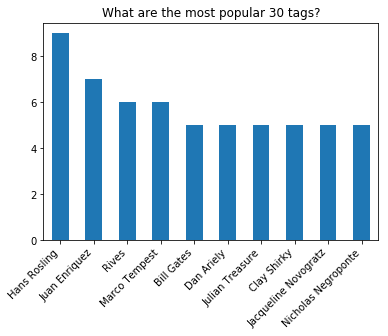

In [28]:
df['main_speaker'].value_counts().sort_values(ascending=False)[:10].plot.bar()
plt.title('What are the most popular 30 tags?')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

### num_speaker
Questions:
<ol>
    <li>What's the distribution of number of speakers? Look at percentages.</li>
</ol>

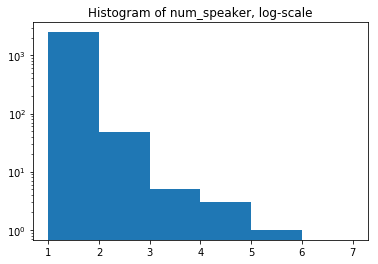

Percentages:


1    97.725490
2     1.921569
3     0.196078
4     0.117647
5     0.039216
Name: num_speaker, dtype: float64

In [29]:
df['num_speaker'].hist(grid=False, bins=range(1, 8))
plt.yscale('log')
plt.title('Histogram of num_speaker, log-scale')
plt.show()

print('Percentages:')
df['num_speaker'].value_counts(normalize=True)*100

### duration
Questions:
<ol>
    <li>What's the distribution of number of speakers?</li>
    <li>Which are the 10 longest talks?</li>
    <li>Which are the 10 shortest talks?</li>
    <li>Average duration</li>
</ol>

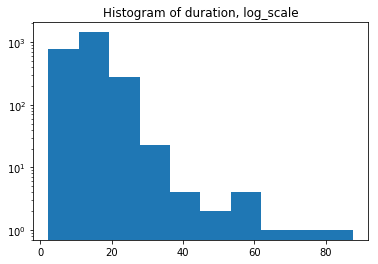

Average duration: 13.775169934640537


In [30]:
fig, ax = plt.subplots(1, 1)

ax.hist(df['duration'])
ax.set_yscale('log')
ax.set_title('Histogram of duration, log_scale')
plt.show()

print('Average duration: ' + str(df['duration'].mean()))

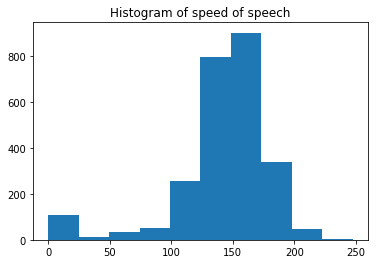

Average speed_of_speech: 142.15111216160395


In [31]:

fig, ax = plt.subplots(1, 1)

ax.hist(df['speed_of_speech'])
ax.set_title('Histogram of speed of speech')
plt.show()

print('Average speed_of_speech: ' + str(df['speed_of_speech'].mean()))

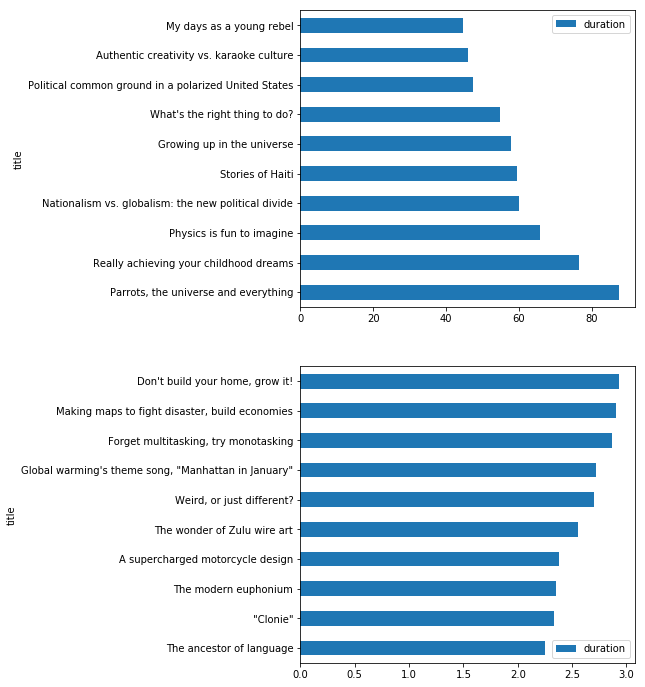

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(6, 12))

bar_plot0 = df[['title', 'duration']].sort_values(by='duration', ascending=False)[:10]
bar_plot0.plot.barh(x='title', y='duration', ax=ax[0])

bar_plot1 = df[['title', 'duration']].sort_values(by='duration')[:10]
bar_plot1.plot.barh(x='title', y='duration', ax=ax[1])
plt.show()

### event
Questions:
<ol>
    <li>How many events do we have?</li>
    <li>How many TEDx events are?</li>
    <li>Which are the first 10 events based on number of talks?</li>
    <li>How many events have only one talk?</li>
</ol>

Number of events: 355
Number of TEDx events: 205


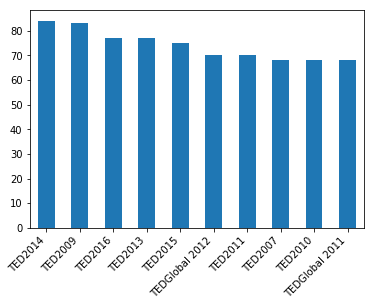

Number of TEDx talks: 471


In [34]:
event_bar_plot = df['event'].value_counts().sort_values(ascending=False)[:10]
event_bar_plot.plot.bar(x = 'event', y = 'count')
plt.xticks(rotation=45, horizontalalignment='right')

print('Number of events: ' + str(df['event'].nunique()))
print('Number of TEDx events: ' + str(len(df[df['event'].str.lower().str.find('tedx')!=-1]['event'].unique())))

plt.show()
print('Number of TEDx talks: ' + str(len(df[df['event'].str.lower().str.find('tedx')!=-1]['event'])))

Number of events with only one talk 30


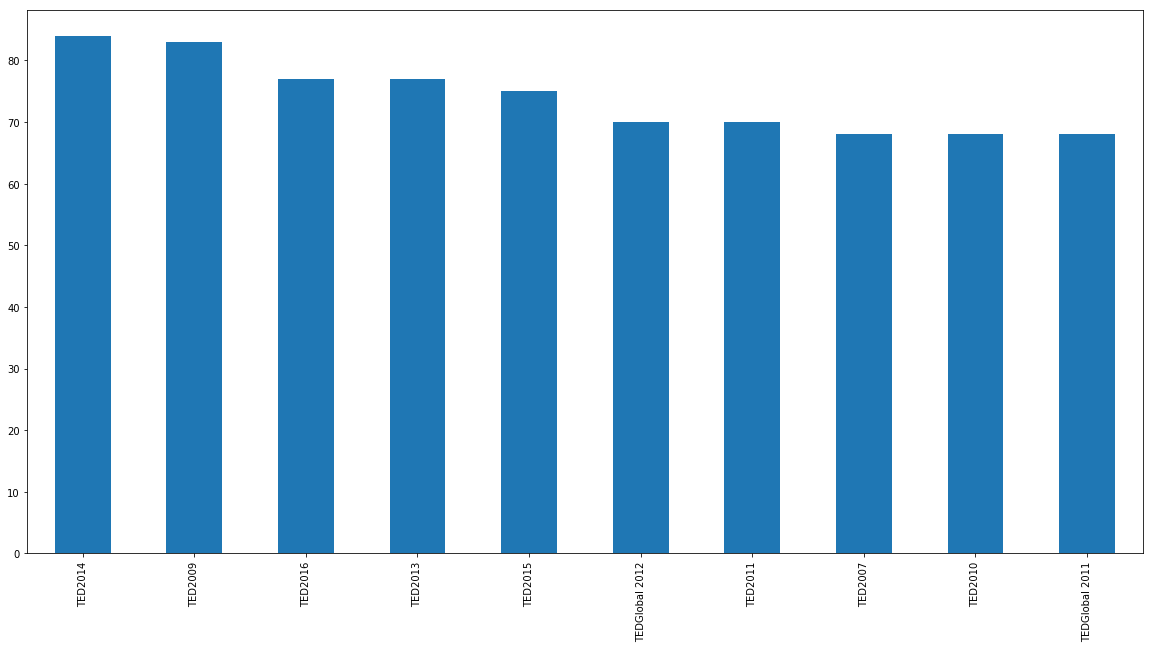

In [35]:
event_bar_plot = df['event'].value_counts().sort_values(ascending=False)[:10]
event_bar_plot.plot.bar(x = 'event', y = 'count', figsize=(20, 10))

print('Number of events with only one talk ' + str((df['event'].value_counts()==3).sum()))

### languages
Sadly, this just tells us the number of languages the talk is available in, and not a list of languages.</br>
Questions:
<ol>
    <li>What's the distribution of languages?</li>
</ol>

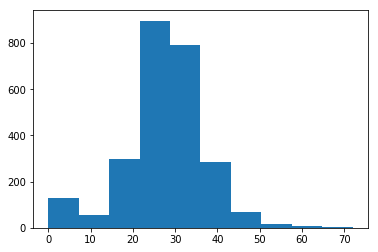

In [36]:
df['languages'].hist(grid=False)

### film_date and published_date
Will analyze the years of the film and published dates.</br>
Questions:
<ol>
    <li>How many ted talks are each year?</li>
    <li>Difference between the date a talk was filmed and the date it was published</li>
    <li>Show the growth over the years</li>
    <li>Oldest talk</li>
</ol>

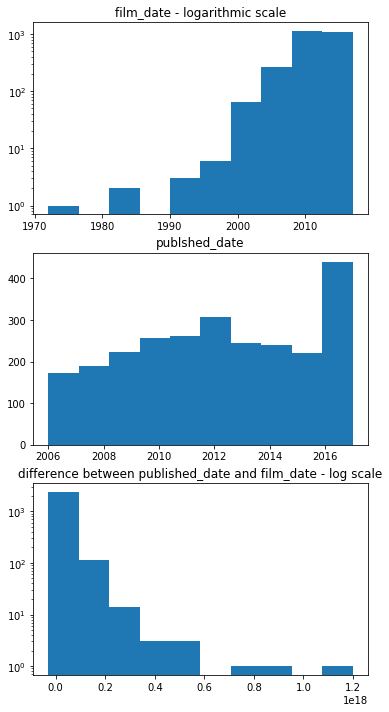

In [37]:
fig, ax = plt.subplots(3, 1, figsize=(6,12))
ax[0].hist(df['film_date'].dt.year)
ax[0].set_yscale('log')
ax[0].set_title('film_date - logarithmic scale')
ax[1].hist(df['published_date'].dt.year)
ax[1].set_title('publshed_date')
ax[2].hist(( df['published_date'] - df['film_date']).astype(int))
ax[2].set_title('difference between published_date and film_date - log scale')
ax[2].set_yscale('log')
plt.show()

In [38]:
# Oldest talk
df.iloc[df['film_date'].dt.year.idxmin()]

talk_id                                                             686
name                               Viktor Frankl: Why believe in others
title                                             Why believe in others
description           In this rare clip from 1972, legendary psychia...
url                   https://www.ted.com/talks/viktor_frankl_youth_...
duration                                                        4.36667
film_date                                           1972-05-14 00:00:00
published_date                                      2010-05-14 00:00:00
number_of_words                                                       0
languages                                                             0
comments                                                            373
views                                                           1028630
main_speaker                                              Viktor Frankl
speaker_occupation                    Psychiatrist, neurologist,

### tags
Questions:
<ol>
    <li>How many talks belong to each tag?</li>
    <li>Most popular 30 tags</li>
</ol>

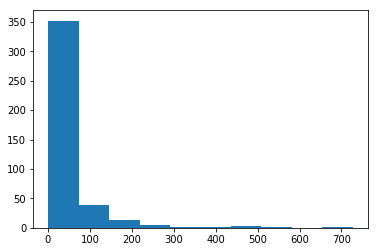

In [39]:
tags_count = pd.Series([y for x in df['tags'] for y in x]).value_counts()
tags_count.hist(grid=False)
plt.show()

In [40]:
print('Total number of tags: ' + str(tags_count.shape[0]))

Total number of tags: 416


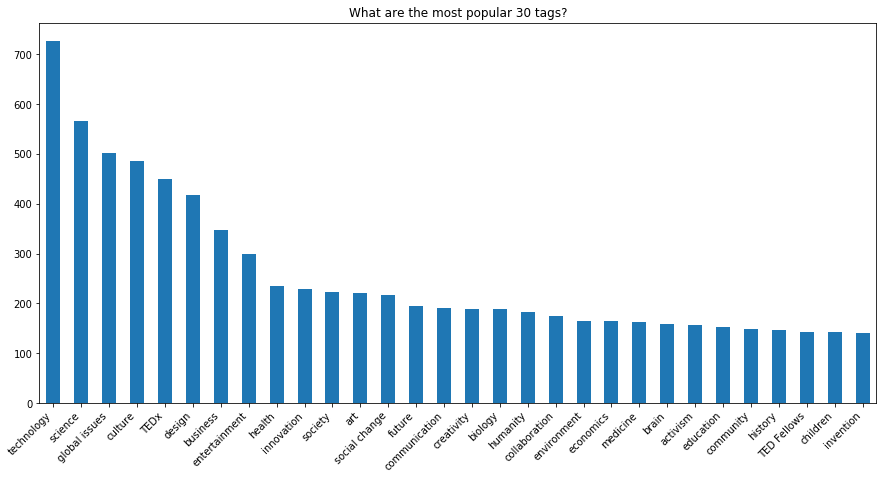

In [41]:
tags_count.sort_values(ascending=False)[:30].plot.bar(figsize=(15,7))
plt.title('What are the most popular 30 tags?')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

### views
Questions:
<ol>
    <li>What is the distribution of views?</li>
    <li>First 10 talks in terms of number of views</li>
</ol>

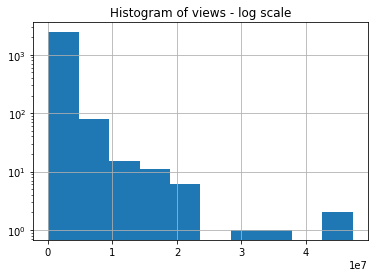

In [42]:
df['views'].hist()
plt.yscale('log')
plt.title('Histogram of views - log scale')
plt.show()

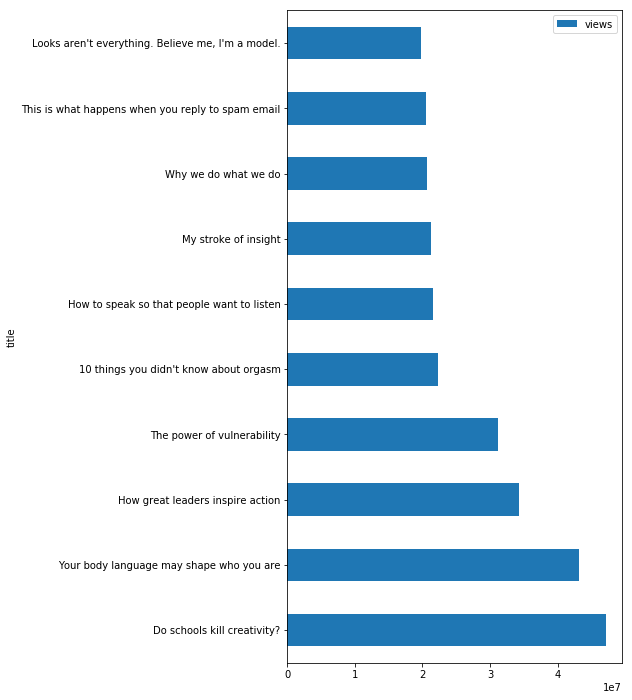

Total number of views: 4330658578


In [43]:
fig, ax = plt.subplots(1, 1, figsize=(6, 12))

bar_plot0 = df[['title', 'views']].sort_values(by='views', ascending=False)[:10]
bar_plot0.plot.barh(x='title', y='views', ax=ax)

plt.show()
print('Total number of views: ' + str(df['views'].sum()))

### comments
Questions:
<ol>
    <li>What is the distribution of comments?</li>
    <li>Which talks have the most comments? First 10</li>
</ol>

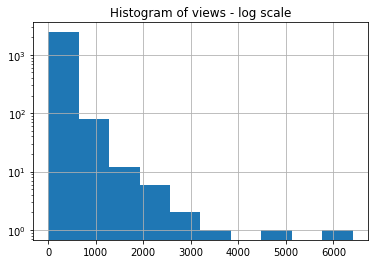

In [44]:
df['comments'].hist()
plt.yscale('log')
plt.title('Histogram of views - log scale')
plt.show()

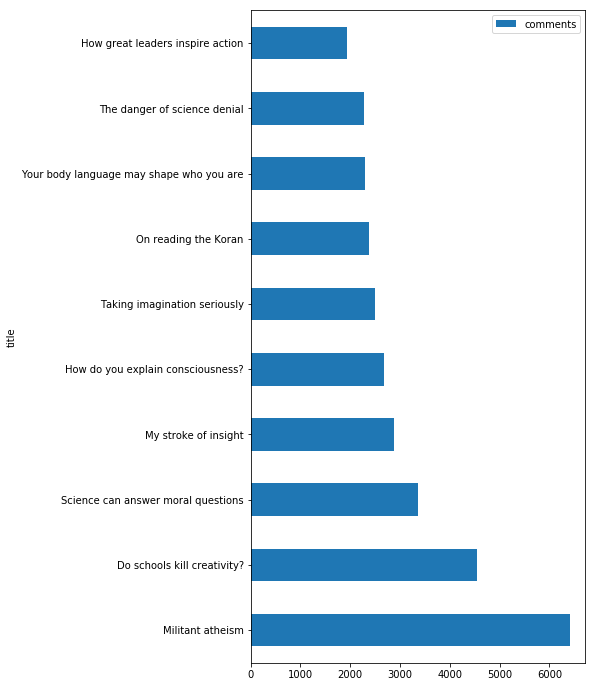

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(6, 12))

bar_plot0 = df[['title', 'comments']].sort_values(by='comments', ascending=False)[:10]
bar_plot0.plot.barh(x='title', y='comments', ax=ax)

plt.show()

### ratings
Questions:
<ol>
    <li>What is the distribution of ratings? Count for each tag how many talks have it at least once.</li>
    <li>For each talk take the rating with the most counts.</li>
</ol>

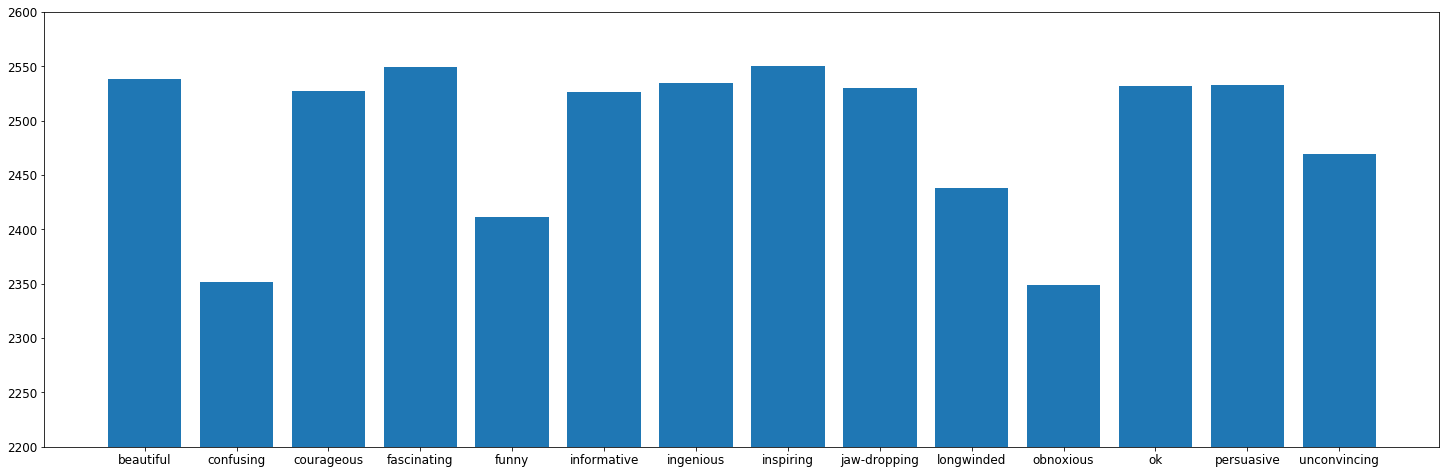

In [46]:
ratings_counts = {}

for name in ratings_name:
    ratings_counts[name] = df[df[name]>1].shape[0]
    
plt.figure(figsize=(25,8))
plt.rcParams.update({'font.size': 12})
plt.bar(range(len(ratings_counts)), list(ratings_counts.values()), align='center')
plt.xticks(range(len(ratings_counts)), list(ratings_counts.keys()))
plt.ylim(2200, 2600)
plt.show()

In [47]:
df.dtypes

talk_id                        int64
name                          object
title                         object
description                   object
url                           object
duration                     float64
film_date             datetime64[ns]
published_date        datetime64[ns]
number_of_words                int64
languages                      int64
comments                       int64
views                          int64
main_speaker                  object
speaker_occupation            object
num_speaker                    int64
speed_of_speech              float64
event                         object
event_type                    object
related_talks                 object
tags                          object
ratings                       object
beautiful                    float64
confusing                    float64
courageous                   float64
fascinating                  float64
funny                        float64
informative                  float64
i

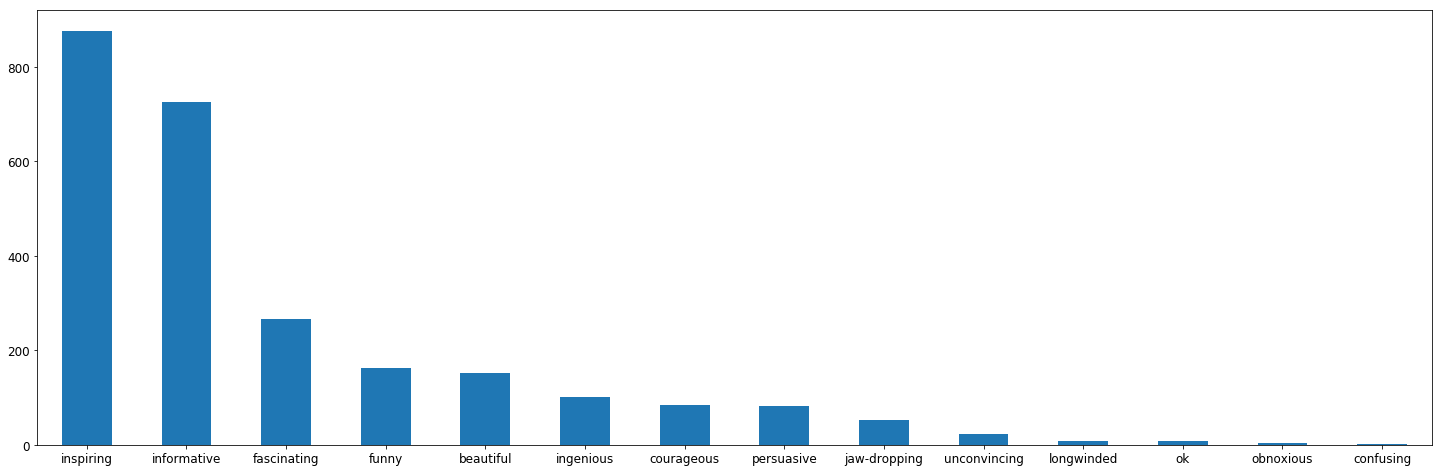

In [48]:
overall_rating = {
    'talk_name': [],
    'best_rating': []
}
for index, talk in df.iterrows():
    overall_rating['talk_name'].append(talk['name'])
    best_rating = talk[ratings_name].astype(float)
    overall_rating['best_rating'].append(best_rating.idxmax())

plt.figure(figsize=(25,8))
overall_rating = pd.DataFrame.from_dict(overall_rating)
overall_rating['best_rating'].value_counts().plot(kind='bar', rot=0)
plt.show()

# Part D Experimental stuff

### Sentiment analysis on transcripts

TODO(Hemilä): Point to the tutorial you used for this and summarize

In [49]:
## WITH MOVIE SAMPLES
##def extract_features(word_list):
##  return dict([(word, True) for word in word_list])
##
#### WITH MOVIE REVIEWS
##positive_fileids = movie_reviews.fileids('pos')
##negative_fileids = movie_reviews.fileids('neg')
##
##features_positive = [(extract_features(movie_reviews.words(fileids=[f])), 
##           'Positive') for f in positive_fileids]
##features_negative = [(extract_features(movie_reviews.words(fileids=[f])), 
##           'Negative') for f in negative_fileids]
##
##threshold_factor = 0.8
##threshold_positive = int(threshold_factor * len(features_positive))
##threshold_negative = int(threshold_factor * len(features_negative))
##
##
##features_train = features_positive[:threshold_positive] + features_negative[:threshold_negative]
##features_test = features_positive[threshold_positive:] + features_negative[threshold_negative:]  
##print( "\nNumber of training datapoints:", len(features_train))
##print( "Number of test datapoints:", len(features_test))
##
##
##classifier = NaiveBayesClassifier.train(features_train)
##
##print("\nTop 10 most informative words:")
##for item in classifier.most_informative_features()[:10]:
##   print(item[0])
##    
##input_reviews = df.transcript


In [50]:
## WITH TWITTER SAMPLES
##def remove_noise(tweet_tokens, stop_words = ()):
##
##    cleaned_tokens = []
##    for token, tag in pos_tag(tweet_tokens):
##        #token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
##        #               '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
##        #token = re.sub("(@[A-Za-z0-9_]+)","", token)
##
##        if tag.startswith("NN"):
##            pos = 'n'
##        elif tag.startswith('VB'):
##            pos = 'v'
##        else:
##            pos = 'a'
##
##        lemmatizer = WordNetLemmatizer()
##        token = lemmatizer.lemmatize(token, pos)
##
##        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
##            cleaned_tokens.append(token.lower())
##    return cleaned_tokens
##
##def get_all_words(cleaned_tokens_list):
##    for tokens in cleaned_tokens_list:
##        for token in tokens:
##            yield token
##
##def get_tweets_for_model(cleaned_tokens_list):
##    for tweet_tokens in cleaned_tokens_list:
##        yield dict([token, True] for token in tweet_tokens)
##        
##        
##        
##
##positive_tweets = twitter_samples.strings('positive_tweets.json')
##negative_tweets = twitter_samples.strings('negative_tweets.json')
##text = twitter_samples.strings('tweets.20150430-223406.json')
##tweet_tokens = twitter_samples.tokenized('positive_tweets.json')[0]
##
##stop_words = stopwords.words('english')
##
##positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
##negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')
##
##positive_cleaned_tokens_list = []
##negative_cleaned_tokens_list = []
##
##for tokens in positive_tweet_tokens:
##    positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))
##
##for tokens in negative_tweet_tokens:
##    negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))
##
##all_pos_words = get_all_words(positive_cleaned_tokens_list)
##
##freq_dist_pos = FreqDist(all_pos_words)
##print(freq_dist_pos.most_common(10))
##
##positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
##negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)
##
##positive_dataset = [(tweet_dict, "Positive")
##                     for tweet_dict in positive_tokens_for_model]
##
##negative_dataset = [(tweet_dict, "Negative")
##                     for tweet_dict in negative_tokens_for_model]
##
##dataset = positive_dataset + negative_dataset
##
##random.shuffle(dataset)
##
##train_data = dataset[:7000]
##test_data = dataset[7000:]
##
##classifier = NaiveBayesClassifier.train(train_data)
##
##print("Accuracy is:", classify.accuracy(classifier, test_data))
##
##print(classifier.show_most_informative_features(10))
